In [1]:
from SyntheticControlMethods import Synth, DiffSynth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import copy
from tqdm import tqdm

### Fit the synthetic control
Here we fit the synthetic control and plot it against the treated outcomes (observed California). Here we also examine the covariate balance between the synthetic and treated outcome.

In [2]:
def synthetic_plot(scm, time, ax=None):
    """
    scm: fitted SyntheticControlMethods object,
    time: array of time indices,
    t0: int, time of treatment,
    ax: matplotlib axes (optional)

    Plot the timeseries of the synthetic control and the treated outcomes.
    """

    # Get synthetic outcomes
    synth_outcome = scm.original_data.synth_outcome.flatten()
    # Get treatment outcomes
    treated_outcome = scm.original_data.treated_outcome_all.flatten()


    if ax == None:
        plt.plot(time, synth_outcome)
        plt.plot(time, treated_outcome)
        plt.legend(['Synthetic', 'Treated'])

        plt.xlabel('Time')
        plt.ylabel('Outcome')
        plt.title('Synthetic control vs. treated outcomes')

    else:
        ax.plot(time, synth_outcome)
        ax.plot(time, treated_outcome)
        ax.legend(['Synthetic', 'Treated'])

        ax.set_xlabel('Time')
        ax.set_ylabel('Outcome')
        ax.set_title('Synthetic control vs. treated outcomes')
    
    return synth_outcome, treated_outcome

In [3]:
def casual_effects(scm, time, ax=None):
    """
    scm: fitted SyntheticControlMethods object,
    time: array of time indices,
    t0: int, time of treatment,
    ax: matplotlib axes (optional)

    Plot the timeseries of the casual effects.
    """

    # Get synthetic outcomes
    synth_outcome = scm.original_data.synth_outcome.flatten()
    # Get treatment outcomes
    treated_outcome = scm.original_data.treated_outcome_all.flatten()

    effects = treated_outcome - synth_outcome


    if ax == None:
        plt.plot(time, effects, c='red')
        plt.set_xlabel('Time')
        plt.set_ylabel('Estiated casual effect')

    else:
        ax.plot(time, effects, c='red')
        ax.set_xlabel('Time')
        ax.set_ylabel('Estiated casual effect')
    
    return effects

In [4]:
def placebo_outcomes(scm):
    """Get the outcomes for in-space placebo test. scm is the original SyntheticControlMethods object
    for the treatment_unit"""
    
    
    df = scm.original_data.dataset # Grab dataset
    id_var = scm.original_data.id # Grab name of unit identifer
    id_treated = scm.original_data.treated_unit # Grab name of the treatment unit
    outcome_var = scm.original_data.outcome_var # Grab name of outcome variable
    time_var = scm.original_data.time # Grab name of the time variable
    treatment_period = scm.original_data.treatment_period # Grab treatment period


    # Get list of donor pool
    donor_pool = df[id_var].unique()
    donor_pool = np.delete(donor_pool, (donor_pool == id_treated).nonzero()) # delete treated unit

    placebo_outcomes = []

    # Run synthetic control method for the placebos
    for placebo in tqdm(donor_pool, desc='Running placebos: '):
        scm_placebo = Synth(dataset=df, outcome_var=outcome_var, id_var=id_var, 
                            time_var=time_var, treatment_period=treatment_period, treated_unit=placebo, n_optim=10)
        # add synthetic outcome for the placebo
        placebo_outcomes.append(scm_placebo.original_data.synth_outcome.flatten())
        
        
    return np.array(placebo_outcomes)

In [5]:
# Read in the data
df = pd.read_csv('Data/data.csv')

In [6]:
df

,state,year,cigsale,lnincome,beer,age15to24,retprice
0,Alabama,1970,89.8,NaN,NaN,0.178862,39.6
1,Alabama,1971,95.4,NaN,NaN,0.179928,42.7
2,Alabama,1972,101.1,9.498476,NaN,0.180994,42.3
3,Alabama,1973,102.9,9.550107,NaN,0.182060,42.1
4,Alabama,1974,108.2,9.537163,NaN,0.183126,43.1
...,...,...,...,...,...,...,...
1204,Wyoming,1996,110.3,10.016768,24.6,NaN,162.5
1205,Wyoming,1997,108.8,10.025613,24.6,NaN,164.1
1206,Wyoming,1998,102.9,NaN,NaN,NaN,168.8
1207,Wyoming,1999,104.8,NaN,NaN,NaN,189.6


In [33]:
# Fit syntehtic control (covariates are averaged in the pre-treatment period)
synth_control = Synth(dataset=df, outcome_var='cigsale', id_var='state', time_var='year', treatment_period=1989, treated_unit='California', n_optim=20)

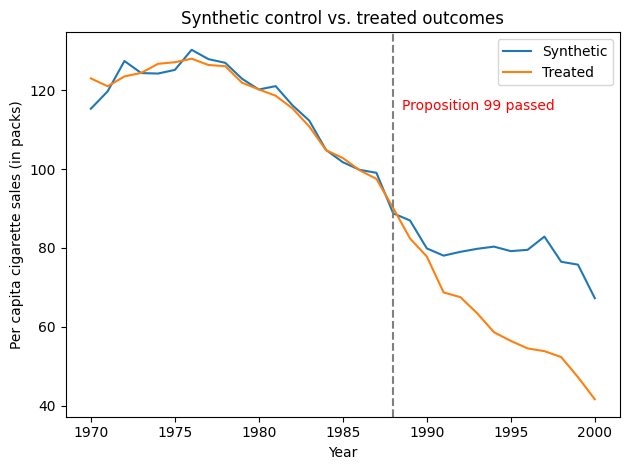

In [34]:
# Visualize the synthetic control vs. the treated outcomes
fig, ax = plt.subplots()
synthetic_plot(synth_control, time=df.year.unique(), ax=ax)

ax.axvline(x=1988, ls='--', c='grey')
ax.text(x=1988.5, y=115, s='Proposition 99 passed', c='red')
ax.set_xlabel('Year')
ax.set_ylabel('Per capita cigarette sales (in packs)')

plt.tight_layout()
plt.savefig('Figures/synth_vs_treated.png', dpi=300)

plt.show()

In [36]:
# Examine covariate balance on pre-treatment period
comparison_df= synth_control.original_data.comparison_df.drop(columns=['WMAPE', 'Importance'])
comparison_df['Average Control Units'] = synth_control.original_data.unscaled_control_covariates.mean(axis=1)
comparison_df['Importance'] = synth_control.original_data.v

comparison_df.index = ['per capita cigarette sales', 'Ln(GDP per capita)', 'per capita beer consumption', 
                       'proportion age 15-24', 'cigarette retail price']

comparison_df.to_csv('Figures/comparison_table.csv')
comparison_df

,California,Synthetic California,Average Control Units,Importance
per capita cigarette sales,116.21,116.21,130.569529,0.152480
Ln(GDP per capita),10.03,9.72,9.792332,0.050145
per capita beer consumption,24.28,22.90,23.655263,0.303108
proportion age 15-24,0.18,0.19,0.178345,0.404752
cigarette retail price,66.64,64.21,64.504571,0.089514


We see that the covariates are reasonably similar between California and the synthetic California. Especially in per capita cigarette sales, the synthetic California does much better than the average of the control units. This is also apparent in the plot above, where the trend of pre-treatment California is closely followed by the synthetic California. This is evidence that the synthetic control provides a reasonable estimate of cigarette sales in California without the passing of Proposition 99.

### Estimated casual effects
The estimated casual effect is the difference between the synthetic and real Califronia in the post-treatment period.

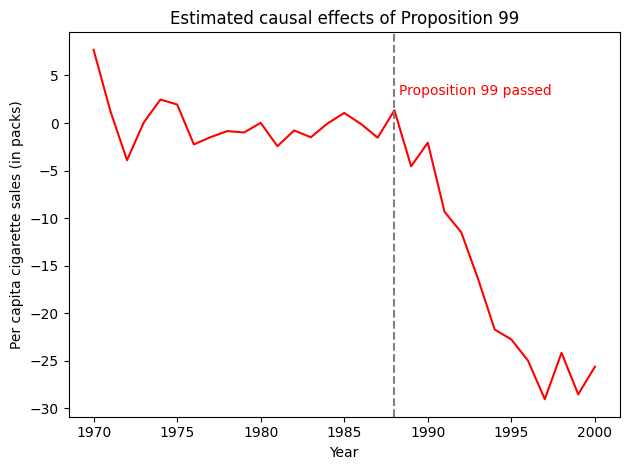

In [37]:
# Visualize the estimated causal effect
fig, ax = plt.subplots()
casual_effects(synth_control, time=df.year.unique(), ax=ax)

ax.axvline(x=1988, ls='--', c='grey')
ax.text(x=1988.3, y=3, s='Proposition 99 passed', c='red')
ax.set_xlabel('Year')
ax.set_ylabel('Per capita cigarette sales (in packs)')
ax.set_title('Estimated causal effects of Proposition 99')

plt.tight_layout()
# save figure
plt.savefig('Figures/causal_effects.png', dpi=300)

plt.show()

Side Note: Assumptions of no interference? 

-Anti-tobacco sentiment in California could have spread to other states and lowered smoking in other states \
-Tobacco companies could increase advertising in California, redirecting funds from other states \
-Cross-border tobacco purchases

However, these effects would only lower smoking rates in the donor pool and reduce our estimated effects. As we find that Proposition 99 is significant despite this fact, these factors are unlikely to undermine this analysis.


### Inference
Under the null hypothesis of no intervention effect, we want to know the probability of observing treatment effects as extreme as we see for California from purely random chance? To answer this question, we employ randomization inference, i.e., we randomly select other states to calculate the "treatment effects" under the synthetic control method and compare them to what we found for California, moving California to the donor pool.

In [11]:
# Run in space placebos
placebos = placebo_outcomes(synth_control)

Running placebos: 100%|██████████| 38/38 [08:02<00:00, 12.69s/it]


In [38]:
# Difference between the placebo outcomes and control outcomes
control_outcomes = synth_control.original_data.control_outcome_all
placebo_differences = control_outcomes - placebos.T

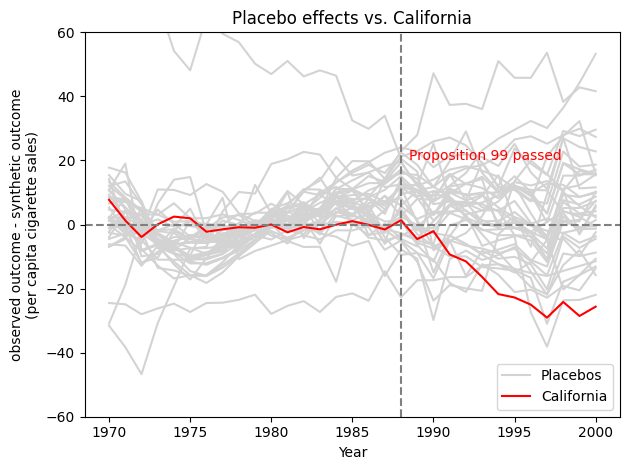

In [39]:
## Plot the placebo estimated effects (placebo observed - synthetic outcomes)
fig, ax = plt.subplots()

# Plot the placebo differences
pd.DataFrame(pd.concat((pd.DataFrame(placebo_differences), df.year), axis=1)).plot(x='year', color='lightgrey', legend=False, ax=ax)

# Add California differences
ca_synth_outcome = synth_control.original_data.synth_outcome.flatten()
ca_treated_outcome = synth_control.original_data.treated_outcome_all.flatten()
ax.plot(df.year.unique(), ca_treated_outcome-ca_synth_outcome, c='red')

# Add horizontal line at zero (measure goodness of fit in pre-intervention period)
ax.axhline(y=0, color='grey', ls='--')

# Add labels for intervention year
ax.axvline(x=1988, ls='--', c='grey')
ax.text(x=1988.5, y=20, s='Proposition 99 passed', c='red')

# Add (custom) legend
custom_lines = [Line2D([0], [0], color='lightgrey'),
                Line2D([0], [0], color='red')]
ax.legend(custom_lines, ['Placebos', 'California'])

ax.set_xlabel('Year')
ax.set_ylabel('observed outcome - synthetic outcome' + '\n' + '(per capita cigarette sales)')
ax.set_title('Placebo effects vs. California')
ax.set_ylim(top=60, bottom=-60)

# Save figure
plt.tight_layout()
plt.savefig('Figures/placebo_effects.png', dpi=300)
plt.show()

In the figure above, we notice a few things:
1. California has a very good pre-treatment fit which again confirms that we found a suitable synthetic control
2. The effects for California in the post-intervention period seems significant (more dramatic) than most of the placebo effects
3. Importantly, several of the placebo synthetic controls do not have good fits in the pre-intervention period - if California had a poor fit in the pre-intervention period, we would say the estimated effects are only due to poor fitting. It does not make sense to compare these to synthetic controls that did have a good fit and should be removed from the plot. But what should the threshold be to decide whether or not we keep a placebo? This can be rather subjective.

In [16]:
# Run in space placebo tests (scm package)
synth_control.in_space_placebo()

In [17]:
# Look at root mean square prediction error between syntehtic control and the observed data - 
# for both the pre-intervention period, post - intervention perdod, respectively.
# Also shows the ratio between the pre and post period

rmspe = synth_control.original_data.rmspe_df
rmspe.head(10)

,unit,pre_rmspe,post_rmspe,post/pre
0,California,2.669407,20.923365,7.838208
1,Alabama,41.785593,53.348992,1.276732
2,Arkansas,49.157994,60.398365,1.228658
3,Colorado,16.491337,3.747221,0.227224
4,Connecticut,9.760905,9.867286,1.010899
5,Delaware,12.105723,31.424519,2.595840
6,Georgia,9.520559,17.108429,1.796998
7,Idaho,41.284545,29.490959,0.714334
8,Illinois,12.980796,9.659365,0.744127
9,Indiana,7.639613,24.286708,3.179050


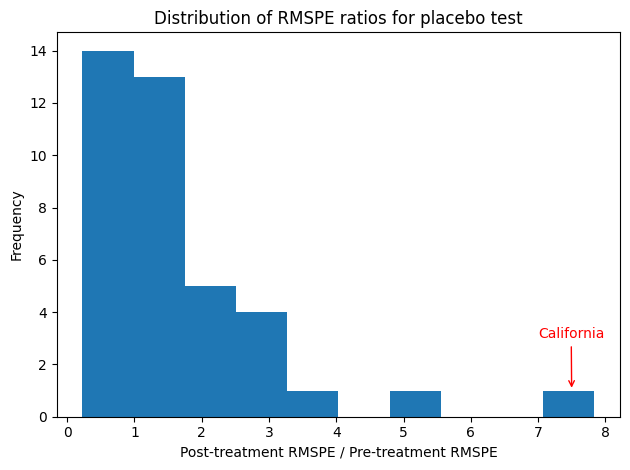

In [18]:
# Draw histogram of null distribution
fig, ax = plt.subplots()
rmspe['post/pre'].hist(ax=ax, grid=False)

# Label California
ax.annotate("California", xy=(7.5, 1), xytext=(7, 3),
            arrowprops=dict(arrowstyle="->", color='red'), color='red')

ax.set_xlabel('Post-treatment RMSPE / Pre-treatment RMSPE')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of RMSPE ratios for placebo test')

plt.tight_layout()
plt.savefig('Figures/Placebo_test_rmspe.png', dpi=300)
plt.show()

In [40]:
# Get ranks
rmspe['ratio_rank'] = rmspe['post/pre'].rank(ascending=False)

# Find the estimated p-value
rmspe.loc[rmspe['unit']=='California', 'ratio_rank'] / len(rmspe.unit)

0    0.025641
Name: ratio_rank, dtype: float64